In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
# from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.neural_network import MLPRegressor

In [38]:
df_1 = pd.read_csv("ResaleFlatPricesBasedonApprovalDate19901999.csv")
df_2 = pd.read_csv("ResaleFlatPricesBasedonApprovalDate2000Feb2012.csv")
df_3 = pd.read_csv("ResaleFlatPricesBasedonRegistrationDateFromMar2012toDec2014.csv")
df_4 = pd.read_csv("ResaleFlatPricesBasedonRegistrationDateFromJan2015toDec2016.csv")
df_5 = pd.read_csv("ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")

In [39]:
merged_df = pd.concat([df_1, df_2, df_3, df_4, df_5], axis=0, ignore_index=True)

In [40]:
merged_df.shape

(929071, 11)

In [41]:
merged_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,NaN
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,NaN
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,NaN
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,NaN
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,NaN


In [42]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929071 entries, 0 to 929070
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                929071 non-null  object 
 1   town                 929071 non-null  object 
 2   flat_type            929071 non-null  object 
 3   block                929071 non-null  object 
 4   street_name          929071 non-null  object 
 5   storey_range         929071 non-null  object 
 6   floor_area_sqm       929071 non-null  float64
 7   flat_model           929071 non-null  object 
 8   lease_commence_date  929071 non-null  int64  
 9   resale_price         929071 non-null  float64
 10  remaining_lease      220021 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 78.0+ MB


In [43]:
merged_df.describe()

,floor_area_sqm,lease_commence_date,resale_price
count,929071.000000,929071.000000,9.290710e+05
mean,95.689645,1988.295320,3.213602e+05
std,25.822343,10.682924,1.710196e+05
min,28.000000,1966.000000,5.000000e+03
25%,73.000000,1981.000000,1.930750e+05
50%,93.000000,1986.000000,2.980000e+05
75%,113.000000,1996.000000,4.180000e+05
max,307.000000,2020.000000,1.588000e+06


In [44]:
merged_df.isnull().sum()

month                       0
town                        0
flat_type                   0
block                       0
street_name                 0
storey_range                0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price                0
remaining_lease        709050
dtype: int64

In [45]:
len(merged_df["remaining_lease"])

929071

In [46]:
null_val_per_remaining_lease = ((merged_df["remaining_lease"].isnull().sum())/len(merged_df["remaining_lease"])) * 100
null_val_per_remaining_lease

np.float64(76.31817159291379)

* As there is around 76% null values in "remaining_lease" column, we can drop this column 

In [47]:
merged_df.drop(columns=["remaining_lease"], inplace=True)

In [48]:
merged_df['sale_month'] = pd.to_datetime(merged_df['month']).dt.month
merged_df['sale_year'] = pd.to_datetime(merged_df['month']).dt.year

In [49]:
merged_df.drop(columns=["month"], inplace=True)

Skewness & Outlier Detection

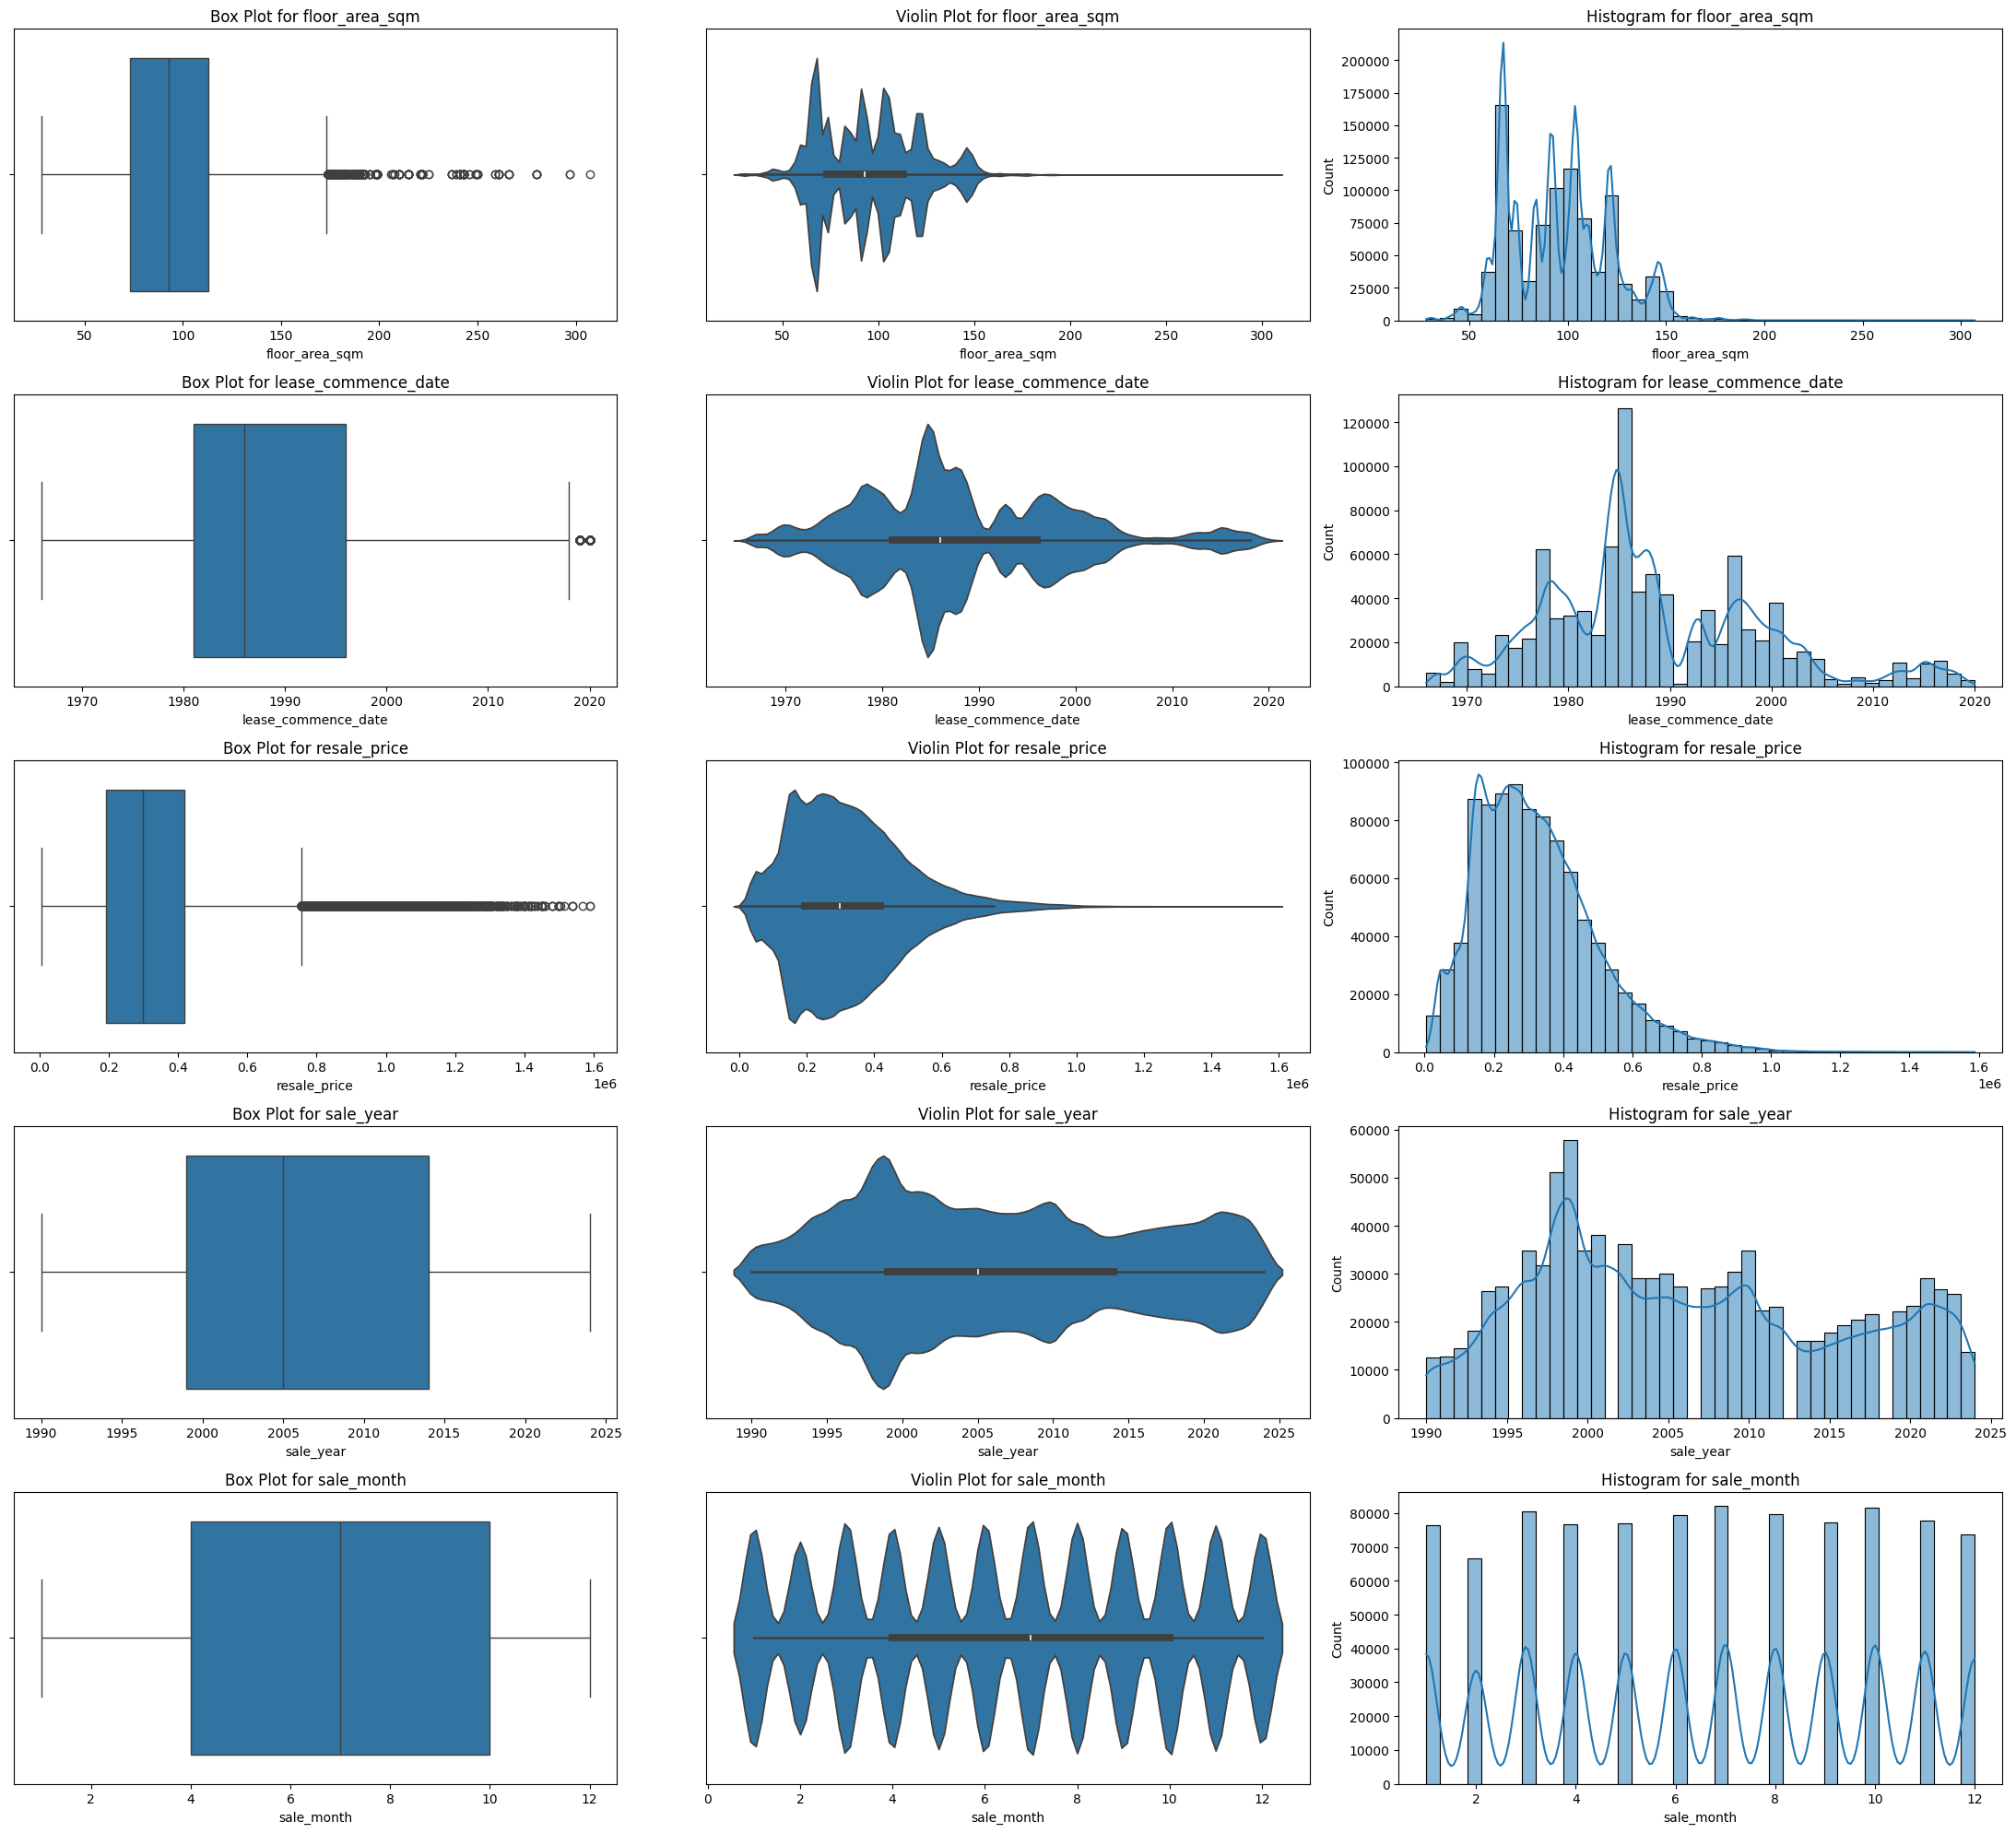

In [16]:
def outlier_skewness_detection(df, columns_plot):
    required_plots = len(columns_plot) * 3
    grid_columns = 3
    grid_rows = (required_plots + grid_columns - 1) // grid_columns
    fig, axes = plt.subplots(grid_rows, grid_columns, figsize = (22,20))
    axes = axes.flatten()

    for i, column in enumerate(columns_plot):
        sns.boxplot(x=df[column], ax=axes[i*3])
        axes[i*3].set_title(f"Box Plot for {column}")
        sns.violinplot(x=df[column], ax=axes[i*3 +1])
        axes[i*3+1].set_title(f"Violin Plot for {column}")
        sns.histplot(x=df[column], kde=True, bins=40, ax=axes[i*3+2])
        axes[i*3+2].set_title(f"Histogram for {column}")

    for j in range(required_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

columns_plot = ['floor_area_sqm', 'lease_commence_date', 'resale_price', 'sale_year', 'sale_month']
outlier_skewness_detection(merged_df, columns_plot)

* From the above plots, it is clear that the features are skewed and contain outliers.
Log transformation for skewness correction

Log transformation for skewness correction


In [50]:

req_log_transformation_col = ['floor_area_sqm', 'resale_price']

for i in req_log_transformation_col:
    merged_df[i] = np.log(merged_df[i])

In [51]:
columns_plot = ['floor_area_sqm',  'resale_price']
outlier_skewness_detection(merged_df, columns_plot)

NameError: name 'outlier_skewness_detection' is not defined

Let's find the outliers data using IQR method

In [52]:
def outlier_rem_IQR(df, col):

    Q1 = df[col].quantile(.25)
    Q3 = df[col].quantile(.75)

    IQR = Q3 - Q1
    lower_threshold = Q1 - 1.5 * IQR
    upper_threshold  = Q3 + 1.5 * IQR

    # df = df[(df[col] >= lower_threshold) & (df[col] <= upper_threshold)]
    df[col] = df[col].clip(lower=lower_threshold, upper=upper_threshold)
    return df

In [53]:
outlier_rem_col = ['resale_price', 'floor_area_sqm']
for i in outlier_rem_col:
    merged_df = outlier_rem_IQR(merged_df, i)
merged_df

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,sale_month,sale_year
0,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,3.635067,IMPROVED,1977,11.012230,1,1990
1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,3.635067,IMPROVED,1977,11.012230,1,1990
2,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,3.635067,IMPROVED,1977,11.012230,1,1990
3,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,3.635067,IMPROVED,1977,11.012230,1,1990
4,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,4.290459,NEW GENERATION,1976,11.012230,1,1990
...,...,...,...,...,...,...,...,...,...,...,...
929066,YISHUN,EXECUTIVE,359,YISHUN RING RD,01 TO 03,4.983607,Maisonette,1988,13.635187,6,2024
929067,YISHUN,EXECUTIVE,723,YISHUN ST 71,10 TO 12,4.983607,Maisonette,1986,13.579788,6,2024
929068,YISHUN,EXECUTIVE,826,YISHUN ST 81,10 TO 12,4.983607,Maisonette,1988,13.815511,6,2024
929069,YISHUN,EXECUTIVE,826,YISHUN ST 81,04 TO 06,4.983607,Maisonette,1988,13.815511,6,2024


In [54]:
merged_df.dtypes


town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
resale_price           float64
sale_month               int32
sale_year                int32
dtype: object

In [55]:
print(merged_df["town"].nunique())
print(merged_df["flat_type"].nunique())
print(merged_df["block"].nunique())
print(merged_df["street_name"].nunique())
print(merged_df["storey_range"].nunique())
print(merged_df["flat_model"].nunique())

27
8
2712
584
25
34


In [56]:
merged_df["flat_model"].unique()

array(['IMPROVED', 'NEW GENERATION', 'MODEL A', 'STANDARD', 'SIMPLIFIED',
       'MODEL A-MAISONETTE', 'APARTMENT', 'MAISONETTE', 'TERRACE',
       '2-ROOM', 'IMPROVED-MAISONETTE', 'MULTI GENERATION',
       'PREMIUM APARTMENT', 'Improved', 'New Generation', 'Model A',
       'Standard', 'Apartment', 'Simplified', 'Model A-Maisonette',
       'Maisonette', 'Multi Generation', 'Adjoined flat',
       'Premium Apartment', 'Terrace', 'Improved-Maisonette',
       'Premium Maisonette', '2-room', 'Model A2', 'DBSS', 'Type S1',
       'Type S2', 'Premium Apartment Loft', '3Gen'], dtype=object)

In [57]:
print(merged_df["storey_range"].unique())

['10 TO 12' '04 TO 06' '07 TO 09' '01 TO 03' '13 TO 15' '19 TO 21'
 '16 TO 18' '25 TO 27' '22 TO 24' '28 TO 30' '31 TO 33' '40 TO 42'
 '37 TO 39' '34 TO 36' '06 TO 10' '01 TO 05' '11 TO 15' '16 TO 20'
 '21 TO 25' '26 TO 30' '36 TO 40' '31 TO 35' '46 TO 48' '43 TO 45'
 '49 TO 51']


In [58]:
def split_storey(data):
    data = data.strip()
    data = data.split()
    avg_storey = int(np.mean([int(data[0]), int(data[-1])]))
    return avg_storey


In [59]:
merged_df["storey"] = merged_df["storey_range"].apply(split_storey)

In [60]:
merged_df.drop(columns=["storey_range"], inplace=True)

Convert all categorical variables to numerical values

In [61]:
# label_encoder = LabelEncoder()

# merged_df['town'] = label_encoder.fit_transform(merged_df['town'])
# merged_df['flat_type'] = label_encoder.fit_transform(merged_df['flat_type'])
# merged_df['block'] = label_encoder.fit_transform(merged_df['block'])
# merged_df['street_name'] = label_encoder.fit_transform(merged_df['street_name'])
# merged_df['flat_model'] = label_encoder.fit_transform(merged_df['flat_model'])

# Create separate label encoders for each column
label_encoders = {
    'town': LabelEncoder(),
    'flat_type': LabelEncoder(),
    'block': LabelEncoder(),
    'street_name': LabelEncoder(),
    'flat_model': LabelEncoder()
}

# Fit and transform the columns using their respective label encoders
for column, le in label_encoders.items():
    merged_df[column] = le.fit_transform(merged_df[column])

# Save all label encoders in a single file
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)


In [63]:
corr = merged_df.corr()
corr["resale_price"].sort_values(ascending=False)

resale_price           1.000000
sale_year              0.689665
flat_type              0.601510
floor_area_sqm         0.598484
lease_commence_date    0.534780
storey                 0.192681
town                   0.084077
street_name            0.057990
block                  0.057490
sale_month             0.009336
flat_model            -0.180782
Name: resale_price, dtype: float64

In [64]:
X = merged_df.drop(columns=["resale_price"])
y = merged_df["resale_price"]

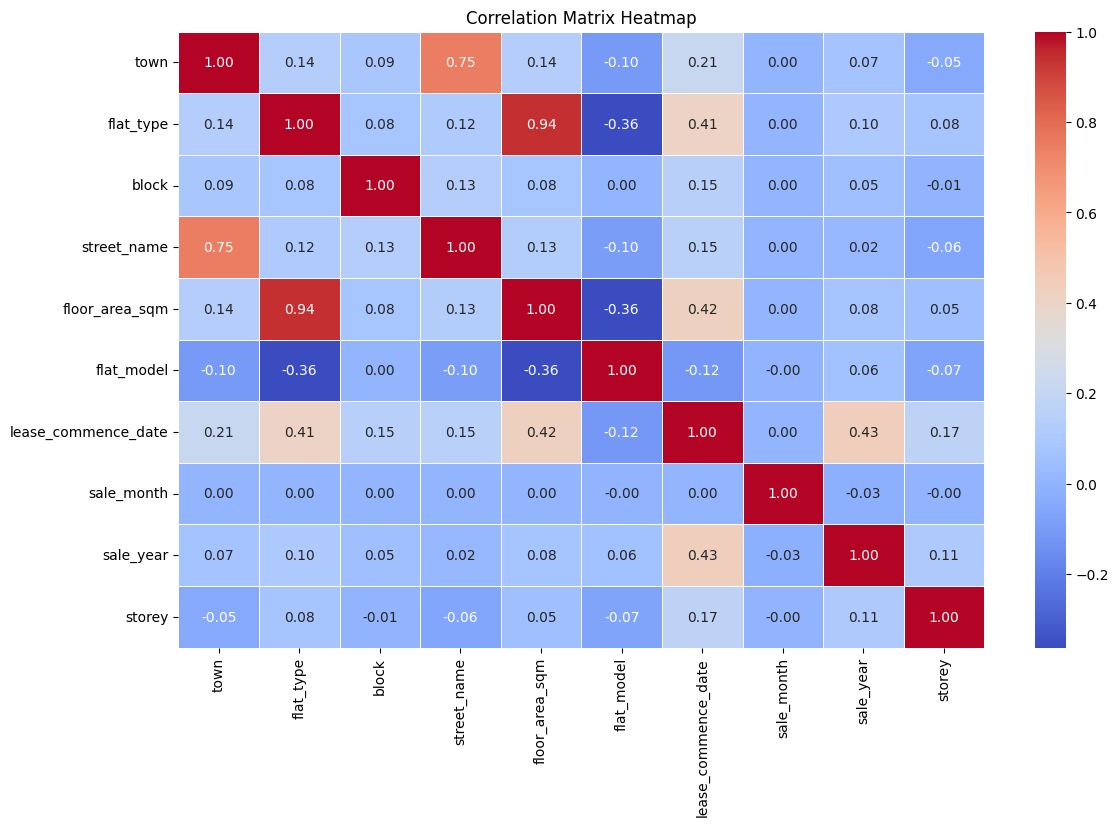

In [65]:
corr = X.corr()
plt.figure(figsize=(13, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

* Street Name, block and sale month are having very less correlation with target variable, so we will drop them 

In [66]:
X.drop(columns=[ "block", "street_name", "sale_month"], inplace=True)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
# Train and evaluate models
def predict_regression(X_train, X_test, y_train, y_test, model):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    
    return mse, rmse, mae, r2, model

In [69]:
models = {
        'Random Forest Regressor': RandomForestRegressor(random_state=42),
        # 'Linear Regression' : LinearRegression(),
        # 'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
        # 'Extra Trees Regressor': ExtraTreesRegressor(random_state=42),
        # 'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42)
}

all_model_price = {}

for model_name, model in models.items():

    print(f"\n{model_name} model :")
    mse, rmse, mae, r2, model = predict_regression(X_train, X_test, y_train, y_test, model)

    all_model_price[model_name] = {"Model": model, "Mean Absolute Error": round(mae,5), "Mean Squared Error": round(mse,5), "Root Mean Squared Error": round(rmse,5), "R2": r2}
    print(all_model_price[model_name])
    print("___________________________________________________________________________________")


Random Forest Regressor model :
{'Model': RandomForestRegressor(random_state=42), 'Mean Absolute Error': np.float64(0.06217), 'Mean Squared Error': np.float64(0.00789), 'Root Mean Squared Error': np.float64(0.08883), 'R2': 0.9764754708667291}
___________________________________________________________________________________


In [71]:
best_model = all_model_price["Random Forest Regressor"]["Model"]
best_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [72]:
# param_grid =   {
#                 'n_estimators'     : [100, 200, 300],
#                 'min_samples_split': [2, 5],
#                 'max_depth'        : [2, 4, 6, 8]   
#                 }

# grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, scoring='accuracy', cv=5,n_jobs=-1)
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_

# # Print the best parameters
# print("Best Parameters:", best_params)

# print("Best Parameters:", grid_search.best_score_)

In [73]:
# Training the model with best parameters
final_rf2_model = best_model

Y_test_pred_rf2 = final_rf2_model.predict(X_test)

mse = mean_squared_error(y_test, Y_test_pred_rf2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, Y_test_pred_rf2)
r2 = r2_score(y_test, Y_test_pred_rf2)

print(f"Mean Absolute Error : {round(mae,5)}")
print(f"Mean Squared Error : {round(mse,5)}")
print(f"Root Mean Squared Error : {round(rmse,5)}")
print(f"R2 Score : {r2}")

Mean Absolute Error : 0.06217
Mean Squared Error : 0.00789
Root Mean Squared Error : 0.08883
R2 Score : 0.9764754708667291


In [74]:
with open("prediction_resale_price_model.pkl", "wb") as f:
    pickle.dump(final_rf2_model, f)